In [79]:
import torch
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
import util
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from time import time
import argparse
from datetime import date
from progressbar import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [2]:
def train_test_split(X, y, train_ratio=0.8):
    num_ts, num_periods, num_features = X.shape
    train_periods = int(num_periods * train_ratio)
    random.seed(2)
    Xtr = X[:, :train_periods, :]
    ytr = y[:, :train_periods]
    Xte = X[:, train_periods:, :]
    yte = y[:, train_periods:]
    return Xtr, ytr, Xte, yte


In [3]:
class Decoder(nn.Module):

    def __init__(
        self, 
        input_size, 
        output_horizon,
        encoder_hidden_size, 
        decoder_hidden_size, 
        output_size):
        super(Decoder, self).__init__()
        self.global_mlp = nn.Linear(output_horizon * (encoder_hidden_size + input_size), (output_horizon+1) * decoder_hidden_size)
        self.local_mlp = nn.Linear(decoder_hidden_size * 2 + input_size, output_size)
        self.decoder_hidden_size = decoder_hidden_size
    
    def forward(self, ht, xf):
        '''
        Args:
        ht (tensor): (1, hidden_size)
        xf (tensor): (output_horizon, num_features)
        '''
        num_ts, output_horizon, num_features = xf.size()
        num_ts, hidden_size = ht.size()
        ht = ht.unsqueeze(1)
        ht = ht.expand(num_ts, output_horizon, hidden_size)
        # inp = (xf + ht).view(batch_size, -1) # batch_size, hidden_size, output_horizon
        inp = torch.cat([xf, ht], dim=2).view(num_ts, -1)
        contexts = self.global_mlp(inp)
        contexts = contexts.view(num_ts, output_horizon+1, self.decoder_hidden_size)
        ca = contexts[:, -1, :].view(num_ts, -1)
        C = contexts[:, :-1, :]
        C = F.relu(C)
        y = []
        for i in range(output_horizon):
            ci = C[:, i, :].view(num_ts, -1)
            xfi = xf[:, i, :].view(num_ts, -1)
            inp = torch.cat([xfi, ci, ca], dim=1)
            out = self.local_mlp(inp) # num_ts, num_quantiles
            y.append(out.unsqueeze(1))
        y = torch.cat(y, dim=1) # batch_size, output_horizon, quantiles
        return y 


class MQRNN(nn.Module):

    def __init__(
        self, 
        output_horizon, 
        num_quantiles, 
        input_size, 
        embedding_size=10,
        encoder_hidden_size=64, 
        encoder_n_layers=3,
        decoder_hidden_size=64
        ):
        '''
        Args:
        output_horizon (int): output horizons to output in prediction
        num_quantiles (int): number of quantiles interests, e.g. 0.25, 0.5, 0.75
        input_size (int): feature size
        embedding_size (int): embedding size
        encoder_hidden_size (int): hidden size in encoder
        encoder_n_layers (int): encoder number of layers
        decoder_hidden_size (int): hidden size in decoder
        '''
        super(MQRNN, self).__init__()
        self.output_horizon = output_horizon
        self.encoder_hidden_size = encoder_hidden_size
        self.input_embed = nn.Linear(1, embedding_size) # time series embedding
        self.encoder = nn.LSTM(input_size + embedding_size, encoder_hidden_size, encoder_n_layers, bias=True, batch_first=True)
        self.decoder = Decoder(input_size, output_horizon, encoder_hidden_size, decoder_hidden_size, num_quantiles)
    
    def forward(self, X, y, Xf):
        '''
        Args:
        X (tensor like): shape (num_time_series, num_periods, num_features)
        y (tensor like): shape (num_time_series, num_periods)
        Xf (tensor like): shape (num_time_series, seq_len, num_features)
        '''
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            Xf = torch.from_numpy(Xf).float()
        num_ts, num_periods, num_features = X.size()
        y = y.unsqueeze(2)
        y = self.input_embed(y)
        x = torch.cat([X, y], dim=2)
        # x = x.unsqueeze(0) # batch, seq_len, embed + num_features
        _, (h, c) = self.encoder(x)
        ht = h[-1, :, :]
        # global mlp
        ht = F.relu(ht)
        ypred = self.decoder(ht, Xf)
        return ypred

    
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int)
    seq_len (int): sequence/encoder/decoder length
    '''
    num_ts, num_periods, _ = X.shape

    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len, :]
    yf = y[batch, t:t+seq_len]
    
    return X_train_batch, y_train_batch, Xf, yf

In [4]:
# batch_generator(X, y, num_obs_to_train, seq_len, batch_size)

In [127]:
def train(X, y, quantiles):
    num_ts, num_periods, num_features = X.shape
    num_quantiles = len(quantiles)
    model = MQRNN(seq_len, num_quantiles, num_features, embedding_size, encoder_hidden_size, n_layers, decoder_hidden_size)
    optimizer = Adam(model.parameters(), lr=lr)
    
    Xtr, ytr, Xte, yte = train_test_split(X, y)
    print("Xtr, ytr, Xte, yte:", Xtr.shape, ytr.shape, Xte.shape, yte.shape)
    
    
    losses = []
    mape_list, mae_list, rmse_list = [], [], []
    
    yscaler = None
    if standard_scaler:
        yscaler = util.StandardScaler()
    elif log_scaler:
        yscaler = util.LogScaler()
    elif mean_scaler:
        yscaler = util.MeanScaler()
    if yscaler is not None:
        ytr = yscaler.fit_transform(ytr)
    
    
    ####################  train  ####################
    progress = ProgressBar()
    for epoch in progress(range(num_epoches)):
        print("Epoch {} start...".format(epoch))
        for step in range(step_per_epoch):
            X_train_batch, y_train_batch, Xf, yf = batch_generator(Xtr, ytr, num_obs_to_train, seq_len, batch_size)

            X_train_tensor = torch.from_numpy(X_train_batch).float()
            y_train_tensor = torch.from_numpy(y_train_batch).float() 

            Xf = torch.from_numpy(Xf).float()
            yf = torch.from_numpy(yf).float()
            ypred = model(X_train_tensor, y_train_tensor, Xf)

            # quantile loss
            loss = torch.zeros_like(yf)
            num_ts = Xf.size(0)
            for q, rho in enumerate(quantiles):
                ypred_rho = ypred[:, :, q].view(num_ts, -1)
                e = ypred_rho - yf
                loss += torch.max(rho * e, (rho - 1) * e)
            loss = loss.mean()

            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    ####################  test  ####################
    for i in range(Xte.shape[1]-num_obs_to_train-seq_len):
#     for i in range(8500):
        print('Prediction:', i)
        X_test = Xte[:, i:i+num_obs_to_train, :].reshape((num_ts, -1, num_features))
        Xf_test = Xte[:, i+num_obs_to_train:i+num_obs_to_train+seq_len, :].reshape((num_ts, -1, num_features))
        y_test = yte[:, i:i+num_obs_to_train].reshape((num_ts, -1))

        if yscaler is not None:
            y_test = yscaler.transform(y_test)
        yf_test = yte[:, i+num_obs_to_train:i+num_obs_to_train+seq_len]

        ypred = model(X_test, y_test, Xf_test) # (1, num_quantiles, output_horizon)
        ypred = ypred.data.numpy()
        ypred = yscaler.inverse_transform(ypred)

        # P50 quantile MAPE 
        mape = util.MAPE(yf_test, ypred[:, :, 1])
        mape_list.append(mape)
#         print("MAPE: {}".format(mape))

        mae = MAE(ypred[:, :, 1], yf_test)
        mae_list.append(mae)
#         print("MAE: {}".format(mae))

        rmse = np.sqrt(MSE(ypred[:, :, 1], yf_test))
        rmse_list.append(rmse)
#         print("RMSE: {}".format(rmse))
    
    return losses, mape_list, mae_list, rmse_list

In [128]:
#if args.run_test:
# data_path = util.get_data_path()
dataset = pd.read_csv("../../..data/pollution.csv")
dataset.fillna(0, inplace=True)
print(dataset.shape)
# dataset

(43800, 12)


In [129]:
dataset['date'] = pd.to_datetime(dataset['date'])
# dataset

In [130]:
dataset['Day of Week'] = dataset['date'].dt.dayofweek
dataset['day'] = dataset['date'].dt.day
dataset['hour'] = dataset['date'].dt.hour
dataset['month'] = dataset['date'].dt.month
dataset = dataset.drop(['date'], axis=1)
dataset

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv,Day of Week,day,hour,month
0,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0,5,2,0,1
1,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0,5,2,1,1
2,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0,5,2,2,1
3,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0,5,2,3,1
4,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0,5,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0,2,31,19,12
43796,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0,2,31,20,12
43797,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0,2,31,21,12
43798,8.0,-22,-4.0,1034.0,246.72,0,0,0,1,0,0,2,31,22,12


In [131]:
num_epoches = 500    # 35040
step_per_epoch = 3
lr = 1e-3
batch_size = 256
n_layers = 3
encoder_hidden_size = 64
decoder_hidden_size = 64
seq_len = 6
num_obs_to_train = 24*3
embedding_size = 24
standard_scaler = True

X.shape, y.shape: (100, 438, 14) (100, 438)
Xtr, ytr, Xte, yte: (100, 350, 14) (100, 350) (100, 88, 14) (100, 88)
Epoch 0 start...
Epoch 1 start...
Epoch 2 start...
Epoch 3 start...


Epoch 4 start...
Epoch 5 start...
Epoch 6 start...
Epoch 7 start...


Epoch 8 start...
Epoch 9 start...
Epoch 10 start...
Epoch 11 start...


Epoch 12 start...
Epoch 13 start...
Epoch 14 start...
Epoch 15 start...


Epoch 16 start...
Epoch 17 start...
Epoch 18 start...
Epoch 19 start...


Epoch 20 start...
Epoch 21 start...
Epoch 22 start...
Epoch 23 start...


Epoch 24 start...
Epoch 25 start...
Epoch 26 start...
Epoch 27 start...


Epoch 28 start...
Epoch 29 start...
Epoch 30 start...
Epoch 31 start...


Epoch 32 start...
Epoch 33 start...
Epoch 34 start...
Epoch 35 start...


Epoch 36 start...
Epoch 37 start...
Epoch 38 start...
Epoch 39 start...


Epoch 40 start...
Epoch 41 start...
Epoch 42 start...
Epoch 43 start...


Epoch 44 start...
Epoch 45 start...
Epoch 46 start...
Epoch 47 start...


Epoch 48 start...
Epoch 49 start...
Epoch 50 start...
Epoch 51 start...


Epoch 52 start...
Epoch 53 start...
Epoch 54 start...
Epoch 55 start...


Epoch 56 start...
Epoch 57 start...
Epoch 58 start...
Epoch 59 start...


Epoch 60 start...
Epoch 61 start...
Epoch 62 start...
Epoch 63 start...


Epoch 64 start...
Epoch 65 start...
Epoch 66 start...
Epoch 67 start...


Epoch 68 start...
Epoch 69 start...
Epoch 70 start...
Epoch 71 start...


Epoch 72 start...
Epoch 73 start...
Epoch 74 start...
Epoch 75 start...


Epoch 76 start...
Epoch 77 start...
Epoch 78 start...
Epoch 79 start...


Epoch 80 start...
Epoch 81 start...
Epoch 82 start...
Epoch 83 start...


Epoch 84 start...
Epoch 85 start...
Epoch 86 start...
Epoch 87 start...


Epoch 88 start...
Epoch 89 start...
Epoch 90 start...
Epoch 91 start...


Epoch 92 start...
Epoch 93 start...
Epoch 94 start...
Epoch 95 start...


Epoch 96 start...
Epoch 97 start...
Epoch 98 start...
Epoch 99 start...


Epoch 100 start...
Epoch 101 start...
Epoch 102 start...
Epoch 103 start...


Epoch 104 start...
Epoch 105 start...
Epoch 106 start...
Epoch 107 start...


Epoch 108 start...
Epoch 109 start...
Epoch 110 start...
Epoch 111 start...


Epoch 112 start...
Epoch 113 start...
Epoch 114 start...
Epoch 115 start...


Epoch 116 start...
Epoch 117 start...
Epoch 118 start...
Epoch 119 start...


Epoch 120 start...
Epoch 121 start...
Epoch 122 start...
Epoch 123 start...


Epoch 124 start...
Epoch 125 start...
Epoch 126 start...
Epoch 127 start...


Epoch 128 start...
Epoch 129 start...
Epoch 130 start...
Epoch 131 start...


Epoch 132 start...
Epoch 133 start...
Epoch 134 start...
Epoch 135 start...


Epoch 136 start...
Epoch 137 start...
Epoch 138 start...
Epoch 139 start...


Epoch 140 start...
Epoch 141 start...
Epoch 142 start...
Epoch 143 start...


Epoch 144 start...
Epoch 145 start...
Epoch 146 start...
Epoch 147 start...


Epoch 148 start...
Epoch 149 start...
Epoch 150 start...
Epoch 151 start...


Epoch 152 start...
Epoch 153 start...
Epoch 154 start...
Epoch 155 start...


Epoch 156 start...
Epoch 157 start...
Epoch 158 start...
Epoch 159 start...


Epoch 160 start...
Epoch 161 start...
Epoch 162 start...
Epoch 163 start...


Epoch 164 start...
Epoch 165 start...
Epoch 166 start...
Epoch 167 start...


Epoch 168 start...
Epoch 169 start...
Epoch 170 start...
Epoch 171 start...


Epoch 172 start...
Epoch 173 start...
Epoch 174 start...
Epoch 175 start...


Epoch 176 start...
Epoch 177 start...
Epoch 178 start...
Epoch 179 start...


Epoch 180 start...
Epoch 181 start...
Epoch 182 start...
Epoch 183 start...


Epoch 184 start...
Epoch 185 start...
Epoch 186 start...
Epoch 187 start...


Epoch 188 start...
Epoch 189 start...
Epoch 190 start...
Epoch 191 start...


Epoch 192 start...
Epoch 193 start...
Epoch 194 start...
Epoch 195 start...


Epoch 196 start...
Epoch 197 start...
Epoch 198 start...
Epoch 199 start...


Epoch 200 start...
Epoch 201 start...
Epoch 202 start...
Epoch 203 start...


Epoch 204 start...
Epoch 205 start...
Epoch 206 start...
Epoch 207 start...


Epoch 208 start...
Epoch 209 start...
Epoch 210 start...
Epoch 211 start...


Epoch 212 start...
Epoch 213 start...
Epoch 214 start...
Epoch 215 start...


Epoch 216 start...
Epoch 217 start...
Epoch 218 start...
Epoch 219 start...


Epoch 220 start...
Epoch 221 start...
Epoch 222 start...
Epoch 223 start...


Epoch 224 start...
Epoch 225 start...
Epoch 226 start...
Epoch 227 start...


Epoch 228 start...
Epoch 229 start...
Epoch 230 start...
Epoch 231 start...


Epoch 232 start...
Epoch 233 start...
Epoch 234 start...
Epoch 235 start...


Epoch 236 start...
Epoch 237 start...
Epoch 238 start...
Epoch 239 start...


Epoch 240 start...
Epoch 241 start...
Epoch 242 start...
Epoch 243 start...


Epoch 244 start...
Epoch 245 start...
Epoch 246 start...
Epoch 247 start...


Epoch 248 start...
Epoch 249 start...
Epoch 250 start...
Epoch 251 start...


Epoch 252 start...
Epoch 253 start...
Epoch 254 start...
Epoch 255 start...


Epoch 256 start...
Epoch 257 start...
Epoch 258 start...
Epoch 259 start...


Epoch 260 start...
Epoch 261 start...
Epoch 262 start...
Epoch 263 start...


Epoch 264 start...
Epoch 265 start...
Epoch 266 start...
Epoch 267 start...


Epoch 268 start...
Epoch 269 start...
Epoch 270 start...
Epoch 271 start...


Epoch 272 start...
Epoch 273 start...
Epoch 274 start...
Epoch 275 start...


Epoch 276 start...
Epoch 277 start...
Epoch 278 start...
Epoch 279 start...


Epoch 280 start...
Epoch 281 start...
Epoch 282 start...
Epoch 283 start...


Epoch 284 start...
Epoch 285 start...
Epoch 286 start...
Epoch 287 start...


Epoch 288 start...
Epoch 289 start...
Epoch 290 start...
Epoch 291 start...


Epoch 292 start...
Epoch 293 start...
Epoch 294 start...
Epoch 295 start...


Epoch 296 start...
Epoch 297 start...
Epoch 298 start...
Epoch 299 start...


Epoch 300 start...
Epoch 301 start...
Epoch 302 start...
Epoch 303 start...


Epoch 304 start...
Epoch 305 start...
Epoch 306 start...
Epoch 307 start...


Epoch 308 start...
Epoch 309 start...
Epoch 310 start...
Epoch 311 start...


Epoch 312 start...
Epoch 313 start...
Epoch 314 start...
Epoch 315 start...


Epoch 316 start...
Epoch 317 start...
Epoch 318 start...
Epoch 319 start...


Epoch 320 start...
Epoch 321 start...
Epoch 322 start...
Epoch 323 start...


Epoch 324 start...
Epoch 325 start...
Epoch 326 start...
Epoch 327 start...


Epoch 328 start...
Epoch 329 start...
Epoch 330 start...
Epoch 331 start...


Epoch 332 start...
Epoch 333 start...
Epoch 334 start...
Epoch 335 start...


Epoch 336 start...
Epoch 337 start...
Epoch 338 start...
Epoch 339 start...


Epoch 340 start...
Epoch 341 start...
Epoch 342 start...
Epoch 343 start...


Epoch 344 start...
Epoch 345 start...
Epoch 346 start...
Epoch 347 start...


Epoch 348 start...
Epoch 349 start...
Epoch 350 start...
Epoch 351 start...


Epoch 352 start...
Epoch 353 start...
Epoch 354 start...
Epoch 355 start...


Epoch 356 start...
Epoch 357 start...
Epoch 358 start...
Epoch 359 start...


Epoch 360 start...
Epoch 361 start...
Epoch 362 start...
Epoch 363 start...


Epoch 364 start...
Epoch 365 start...
Epoch 366 start...
Epoch 367 start...


Epoch 368 start...
Epoch 369 start...
Epoch 370 start...
Epoch 371 start...


Epoch 372 start...
Epoch 373 start...
Epoch 374 start...
Epoch 375 start...


Epoch 376 start...
Epoch 377 start...
Epoch 378 start...
Epoch 379 start...


Epoch 380 start...
Epoch 381 start...
Epoch 382 start...
Epoch 383 start...


Epoch 384 start...
Epoch 385 start...
Epoch 386 start...
Epoch 387 start...


Epoch 388 start...
Epoch 389 start...
Epoch 390 start...
Epoch 391 start...


Epoch 392 start...
Epoch 393 start...
Epoch 394 start...
Epoch 395 start...


Epoch 396 start...
Epoch 397 start...
Epoch 398 start...
Epoch 399 start...


Epoch 400 start...
Epoch 401 start...
Epoch 402 start...
Epoch 403 start...


Epoch 404 start...
Epoch 405 start...
Epoch 406 start...
Epoch 407 start...


Epoch 408 start...
Epoch 409 start...
Epoch 410 start...
Epoch 411 start...


Epoch 412 start...
Epoch 413 start...
Epoch 414 start...
Epoch 415 start...


Epoch 416 start...
Epoch 417 start...
Epoch 418 start...
Epoch 419 start...


Epoch 420 start...
Epoch 421 start...
Epoch 422 start...
Epoch 423 start...


Epoch 424 start...
Epoch 425 start...
Epoch 426 start...
Epoch 427 start...


Epoch 428 start...
Epoch 429 start...
Epoch 430 start...
Epoch 431 start...


Epoch 432 start...
Epoch 433 start...
Epoch 434 start...
Epoch 435 start...


Epoch 436 start...
Epoch 437 start...
Epoch 438 start...
Epoch 439 start...


Epoch 440 start...
Epoch 441 start...
Epoch 442 start...
Epoch 443 start...


Epoch 444 start...
Epoch 445 start...
Epoch 446 start...
Epoch 447 start...


Epoch 448 start...
Epoch 449 start...
Epoch 450 start...
Epoch 451 start...


Epoch 452 start...
Epoch 453 start...
Epoch 454 start...
Epoch 455 start...


Epoch 456 start...
Epoch 457 start...
Epoch 458 start...
Epoch 459 start...


Epoch 460 start...
Epoch 461 start...
Epoch 462 start...
Epoch 463 start...


Epoch 464 start...
Epoch 465 start...
Epoch 466 start...
Epoch 467 start...


Epoch 468 start...
Epoch 469 start...
Epoch 470 start...
Epoch 471 start...


Epoch 472 start...
Epoch 473 start...
Epoch 474 start...
Epoch 475 start...


Epoch 476 start...
Epoch 477 start...
Epoch 478 start...
Epoch 479 start...


Epoch 480 start...
Epoch 481 start...
Epoch 482 start...
Epoch 483 start...


Epoch 484 start...
Epoch 485 start...
Epoch 486 start...
Epoch 487 start...


Epoch 488 start...
Epoch 489 start...
Epoch 490 start...
Epoch 491 start...


Epoch 492 start...
Epoch 493 start...
Epoch 494 start...
Epoch 495 start...


Epoch 496 start...
Epoch 497 start...
Epoch 498 start...
Epoch 499 start...


100% |######################################################################################################################################################|
/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 0
Prediction: 1


/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 2
Prediction: 3


/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 4
Prediction: 5


/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 6
Prediction: 7


/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))
/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


Prediction: 8
Prediction: 9
[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf] [26.288531436920167, 27.946911525726318, 28.580169378916423, 26.035477917989095, 27.154610214233397, 24.664964663187664, 23.466374429066974, 22.72838316599528, 23.223299910227457, 24.056819356282556] [43.97046888835334, 46.42773962257814, 48.365754870145885, 42.37603302339299, 42.8140064737483, 39.05863235095154, 35.284643190345804, 34.65922926365412, 37.28161594967524, 40.40897694421231]
====== MAPE, MAE, RMSE ======
inf 25.414554199854532 41.064710057705774


/disk/delphi/users/jshi008/Project_Collection/demand_forecast-master/util.py:57: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((ytrue - ypred) / ytrue))


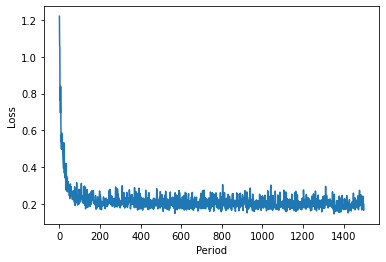

In [132]:
X_df = dataset.loc[:, ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv', 'Day of Week'
                    , 'day', 'hour', 'month']]
y_df = dataset.loc[:, ['pollution']]
X = np.array(X_df)
y = np.array(y_df)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


num_features = X.shape[1]
num_periods = len(X) // 100
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(y).reshape((-1, num_periods))
print("X.shape, y.shape:", X.shape, y.shape)

quantiles = [0.1, 0.5, 1]  # 0.1, 0.5, 1
losses, test_mape, test_mae, test_rmse = train(X, y, quantiles)
print(test_mape, test_mae, test_rmse)


print('====== MAPE, MAE, RMSE ======')
print(sum(test_mape) / len(test_mape),
      sum(test_mae) / len(test_mae), 
      sum(test_rmse) / len(test_rmse))


plt.plot(range(len(losses)), losses)
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()